In [166]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt




In [167]:
songsFeatures = pd.read_csv('musicDataModel.csv')
songsFeatures.dropna(inplace=True)

In [168]:
class_counts = songsFeatures['genre'].value_counts()
print(class_counts)

genre
indie                    1795
rock                     1530
pop                      1241
electronic                753
folk                      574
                         ... 
powerviolence               1
progressive deathcore       1
nasheed                     1
power noise                 1
future garage               1
Name: count, Length: 463, dtype: int64


In [169]:
# Definir un umbral
threshold = 3

# Obtener las clases que tienen más de `threshold` ejemplos
classes_to_keep = class_counts[class_counts >= threshold].index

# Filtrar el DataFrame para mantener solo las clases que están por encima del umbral
songsFeatures_filtered = songsFeatures[songsFeatures['genre'].isin(classes_to_keep)]

# Mostrar el DataFrame filtrado
print("\nDataFrame filtrado:")
print(songsFeatures_filtered['genre'].value_counts())



DataFrame filtrado:
genre
indie                 1795
rock                  1530
pop                   1241
electronic             753
folk                   574
                      ... 
skate punk               3
new jack swing           3
minimalism               3
witch house              3
progressive trance       3
Name: count, Length: 267, dtype: int64


In [170]:
X = songsFeatures_filtered.drop(columns = 'genre')
y = songsFeatures_filtered['genre']

In [171]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Ajustar a todo el conjunto


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [172]:
# Listas de columnas numéricas y categóricas
numerical_features = [
    'rms', 'zcr', 'tempo_x', 'onset_strength', 'mfcc_1', 'mfcc_2', 'mfcc_3',
    'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
    'mfcc_11', 'mfcc_12', 'mfcc_13', 'spectral_contrast_1', 'spectral_contrast_2',
    'spectral_contrast_3', 'spectral_contrast_4', 'spectral_contrast_5',
    'spectral_contrast_6', 'spectral_contrast_7', 'artist_pop', 'track_pop',
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms'
]
categorical_features = ['key', 'mode', 'time_signature']


In [173]:
# Preprocesadores para columnas numéricas y categóricas
# Preprocesadores para columnas numéricas y categóricas con imputación
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación de la media para columnas numéricas
    ('scaler', StandardScaler())  # Escalado
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación de la moda para columnas categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación one-hot
])

# ColumnTransformer para aplicar preprocesamiento específico
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [174]:
pipelineRF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

In [175]:
pipelineXGB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42))
])

In [176]:

pipelineSVC = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=10, gamma='auto', class_weight='balanced'))
])

In [177]:
pipelines = [
    pipelineSVC,
    pipelineRF,
    pipelineXGB
]
model_names = ['Random Forest', 'Logistic Regression', 'SVM']


/home/linky/Proyects/Spotipy/download-data-spotify/FinalDataset/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linky/Proyects/Spotipy/download-data-spotify/FinalDataset/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linky/Proyects/Spotipy/download-data-spotify/FinalDataset/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

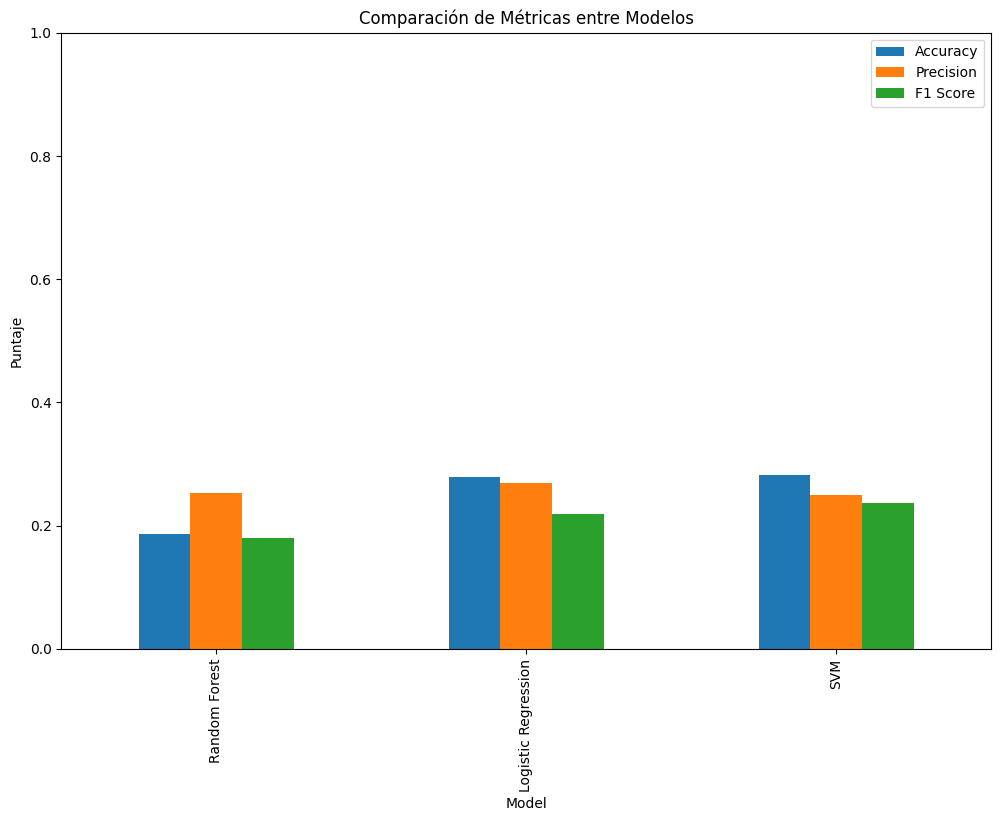

In [178]:
# Inicializa una lista para almacenar los puntajes
scores = []

for model, name in zip(pipelines, model_names):
    # Entrena y predice
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    scores.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'F1 Score': f1})

# Convierte a DataFrame
extended_results_df = pd.DataFrame(scores)

# Gráficas adicionales para cada métrica
extended_results_df.set_index('Model').plot(kind='bar', figsize=(12, 8))
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Puntaje')
plt.ylim(0, 1)
plt.show()